In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", message=".*defaulting to pandas implementation.*")
pd.set_option('display.float_format', '{:.6f}'.format)

# Import Model

In [2]:
jupyter_dir = os.path.abspath(str(Path()))
jupyter_dir

'E:\\git\\machine-learning-option-pricing'

In [3]:
models_path = os.path.join(jupyter_dir,'trained_models','trained_models')
models = os.listdir(models_path)
for i, path in enumerate(models):
    print(f"{i}   {path}")

0   .DS_Store
1   .ipynb_checkpoints
2   2024_10_09 23-01-12 Deep Neural Network otm
3   2024_10_09 23-11-23 Deep Neural Network
4   2024_10_10 11-56-07 Deep Neural Network
5   2024_10_10 12-04-22 Deep Neural Network
6   2024_10_11 10-19-52 Deep Neural Network
7   2024_10_11 11-25-11 Deep Neural Network
8   2024_10_11 12-08-00 Deep Neural Network
9   2024_10_11 12-45-52 Deep Neural Network
10   2024_10_11 17-10-51 Deep Neural Network
11   2024_10_12 01-15-59 Deep Neural Network
12   2024_10_18 23-01-08 Deep Neural Network
13   2024_10_19 00-44-24 Deep Neural Network
14   2024_10_19 00-59-10 Deep Neural Network
15   2024_10_19 11-37-13 Deep Neural Network
16   2024_10_19 11-39-02 Deep Neural Network 61RMSE
17   2024_10_19 16-43-10 Deep Neural Network 18RMSE
18   2024_10_19 16-43-47 Deep Neural Network 18RMSE
19   2024_10_19 16-46-11 Deep Neural Network 60RMSE
20   2024_10_19 16-47-17 Deep Neural Network 47RMSE


In [4]:
model = models[-1]
model

'2024_10_19 16-47-17 Deep Neural Network 47RMSE'

In [5]:
model_path = os.path.join(models_path,'2024_10_11 12-45-52 Deep Neural Network')

In [6]:
model_files = os.listdir(model_path)
model_files

['2024_10_11 12-45-52 Deep Neural Network insample.csv',
 '2024_10_11 12-45-52 Deep Neural Network outsample.csv',
 '2024_10_11 12-45-52 Deep Neural Network.pkl',
 '2024_10_11 12-45-52 Deep Neural Network.txt']

In [7]:
spec_path = os.path.join(model_path,[file for file in model_files if file.endswith('.txt')][0])

In [8]:
import joblib

In [9]:
model_fit = joblib.load(os.path.join(model_path,[file for file in model_files if file.endswith('.pkl')][0]))

In [10]:
with open(spec_path, "r") as specs:
    for line in specs:
        print(line.strip())

Fri Oct 11 12:44:49 2024
spot(s):
[1274.24 1276.84 1288.77 1293.41 1298.46 1304.46 1308.8  1311.13 1314.51
1314.81 1315.19 1317.94 1318.45 1320.45 1322.21 1322.24 1325.42 1325.9
1326.38 1326.79 1328.62 1329.65 1329.75 1330.53 1330.91 1331.14 1331.49
1333.24 1333.44 1333.8  1334.79 1335.63 1336.97 1337.24 1338.18 1338.73
1339.01 1340.15 1340.92 1342.48 1342.83 1348.8  1348.82 1348.83 1349.69
1349.91 1350.78 1351.52 1352.69 1353.69 1353.73 1354.63 1354.95 1358.24
1359.88 1360.   1360.03 1360.47 1360.48 1362.14 1363.84 1365.56 1365.65
1366.54 1367.41 1367.69 1369.22 1369.79 1370.68 1371.44 1372.41 1372.91
1374.2  1376.17 1376.18 1376.5  1377.07 1377.59 1377.99 1379.83 1380.11
1380.72 1380.79 1381.38 1385.23 1385.42 1385.74 1386.77 1386.98 1387.16
1388.04 1388.3  1388.63 1390.08 1390.45 1390.84 1391.01 1391.18 1391.82
1392.05 1392.46 1394.07 1395.   1395.15 1396.31 1397.45 1398.   1398.05
1399.4  1399.96 1401.2  1401.5  1401.77 1402.74 1403.05 1403.12 1403.51
1403.52 1406.48 1406.58 1406.6

In [11]:
model_files

['2024_10_11 12-45-52 Deep Neural Network insample.csv',
 '2024_10_11 12-45-52 Deep Neural Network outsample.csv',
 '2024_10_11 12-45-52 Deep Neural Network.pkl',
 '2024_10_11 12-45-52 Deep Neural Network.txt']

In [12]:
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")

outsample_path = os.path.join(model_path,[file for file in model_files if file.find('outsample') != -1][0])
outsample = pd.read_csv(outsample_path).iloc[:,1:]

insample_path = os.path.join(model_path,[file for file in model_files if file.find('insample') != -1][0])
insample = pd.read_csv(insample_path).iloc[:,1:]

# Test Model

In [13]:
maturities = outsample['days_to_maturity'].unique().tolist()
barrier_type_names = outsample['barrier_type_name'].unique().tolist()
ws = outsample['w'].unique().tolist()
print(f"\nmaturities:\n     maturities = {maturities}")
print(f"\ntypes:\n     barrier_type_names = {barrier_type_names}\n     ws = {ws}\n")


maturities:
     maturities = [60, 90, 180, 360, 540, 720]

types:
     barrier_type_names = ['DownOut', 'DownIn', 'UpOut', 'UpIn']
     ws = ['put', 'call']



In [14]:
by_wbt = outsample.copy().set_index(['w','barrier_type_name','days_to_maturity']).sort_index()

In [15]:
RMSE = pd.DataFrame(
    np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
    columns = barrier_type_names,
    index = maturities
)

for t in maturities:
    for b in barrier_type_names:
        RMSE.loc[t,b] = np.sqrt(np.average((by_wbt.loc[(slice(None), b, t),'outofsample_error'])**2))
print(f"\nRMSE:\n{RMSE}")


RMSE:
      DownOut    DownIn     UpOut      UpIn
60  14.464611 14.128014 15.480705 17.892786
90  13.411065 12.356520 12.897013 16.261613
180 14.465497 12.516362 11.576552 15.133375
360 14.285705 13.114471 10.551158 14.992325
540 13.917252 13.824221 10.457383 14.569312
720 14.729111 16.942909 11.628011 12.237543


In [16]:
MAE = pd.DataFrame(
    np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
    index = maturities,
    columns = barrier_type_names
)
for t in maturities:
    for b in barrier_type_names:
        MAE.loc[t,b] = np.average(np.abs(by_wbt.loc[(slice(None), b, t),'outofsample_error']))
print(f"\nMAE:\n{MAE}")


MAE:
      DownOut    DownIn     UpOut      UpIn
60   8.839602  8.984878 11.286540 10.667579
90   8.099856  7.428498  8.875588  9.300975
180  9.357800  7.874801  7.970261  8.553640
360  8.917415  8.109636  7.344790  9.163510
540  8.906035  8.457959  6.927285  9.689336
720 10.057571 10.703680  8.126924  9.337396


In [17]:
errors_bypayoff = {}
for w in ws:
    errors = {}
    print(
        f"\n         {'#'*(len(w)+5)}"
        f"\n         # {w}s #"
        f"\n         {'#'*(len(w)+5)}"
    )
    RMSE = pd.DataFrame(
        np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
        columns = barrier_type_names
        )
    RMSE[w] = maturities
    RMSE = RMSE.set_index(w,drop=True)
    for t in maturities:
        for b in barrier_type_names:
            RMSE.loc[t,b] = np.sqrt(np.average((by_wbt.loc[(w, b, t),'outofsample_error'])**2))
    print(f"RMSE:\n{RMSE}")
    print()
    errors['RMSE'] = RMSE
    


    MAE = pd.DataFrame(
        np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
        columns = barrier_type_names
    )
    MAE[w] = maturities
    MAE = MAE.set_index(w,drop=True)
    for t in maturities:
        for b in barrier_type_names:
            MAE.loc[t,b] = np.average(np.abs(by_wbt.loc[(w, b, t),'outofsample_error']))
    print(f"MAE:\n{MAE}")
    print()
    errors['MAE'] = MAE
    errors_bypayoff[w] = errors


         ########
         # puts #
         ########
RMSE:
      DownOut    DownIn     UpOut      UpIn
put                                        
60  12.039250 17.669908 16.367519 13.842776
90   9.247909 15.369560 14.768029 12.824167
180  9.839677 15.790292 13.974619 12.290799
360  9.561107 17.239101 13.125419 12.384195
540  8.518274 17.871992 13.302676 11.220778
720 10.360973 20.626447 14.620890 10.102537

MAE:
     DownOut    DownIn     UpOut     UpIn
put                                      
60  9.346600 11.707462 11.204323 7.016355
90  6.870979  9.164596 10.056196 6.285447
180 7.684554 10.075869  9.847285 5.708505
360 7.111389 11.444895  9.445869 6.295932
540 5.465944 11.587998  9.335758 6.743239
720 6.759296 13.970801 10.505010 6.985419


         #########
         # calls #
         #########
RMSE:
       DownOut    DownIn     UpOut      UpIn
call                                        
60   16.358255  8.153145 14.441160 21.197449
90   16.294504  7.632583 10.455939 19.193996


In [18]:
max_MAE = max(errors['MAE'].values.flatten())
max_RMSE = max(errors['RMSE'].values.flatten())
plot_height = max(max_RMSE,max_MAE)*1.05
maturities = errors['MAE'].index.astype(str).tolist()

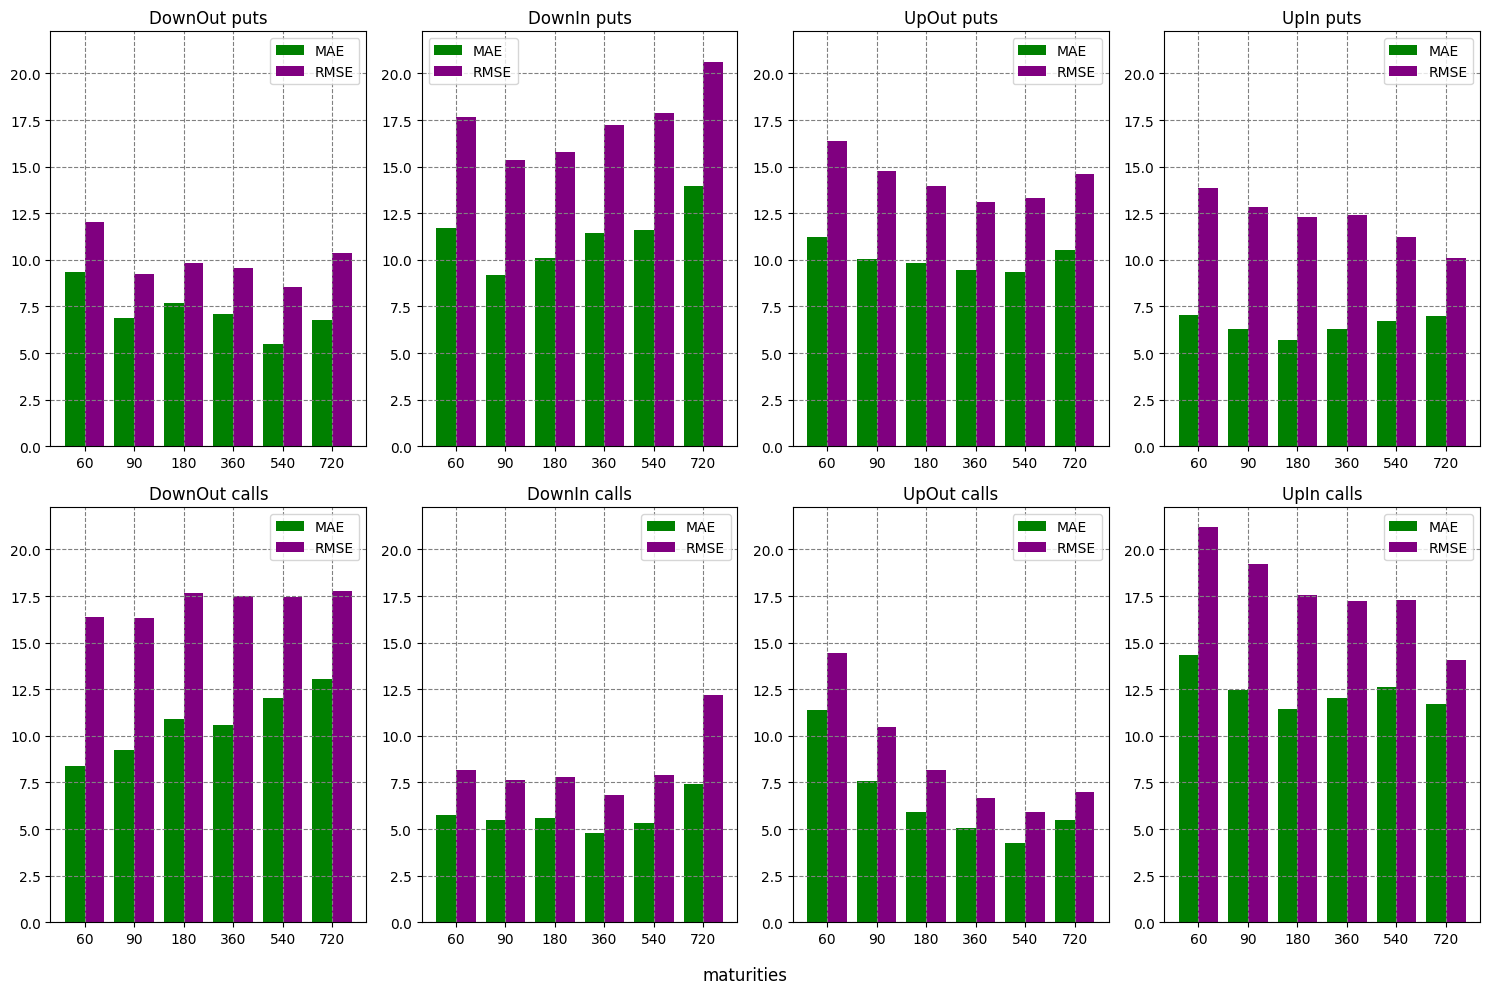

In [19]:
fig, axs = plt.subplots(2, 4, figsize=(15,10))
bar_width = 0.4
i = 0
for w, errors in errors_bypayoff.items():
    for b in barrier_type_names:

        MAE = errors['MAE'][b]
        RMSE = errors['RMSE'][b]
        x_positions = range(len(maturities))
        axs[i // 4, i % 4].grid(True,which='both', linestyle='--', color='gray')
        axs[i // 4, i % 4].bar(
            [x - 0.5 * bar_width for x in x_positions], MAE, width=bar_width, color='green',label="MAE"
        )
        
        axs[i // 4, i % 4].bar(
            [x + 0.5 * bar_width for x in x_positions], RMSE, width=bar_width, color='purple', label="RMSE"
        )
        axs[i // 4, i % 4].set_title(f'{b} {w}s')
        axs[i // 4, i % 4].set_xticks(x_positions)
        axs[i // 4, i % 4].set_xticklabels(maturities)
        axs[i // 4, i % 4].set_ylim(0, plot_height)
        axs[i // 4, i % 4].legend()
        i += 1

fig.supxlabel('maturities')

plt.tight_layout()
plt.show()

In [20]:
by_wbt.loc[('put','DownIn',slice(None)),:].describe()

,spot_price,strike_price,barrier,barrier_price,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,moneyness,observed_price,outofsample_target,outofsample_prediction,outofsample_error
count,117529.000000,117529.000000,117529.000000,117529.000000,117529.000000,117529.000000,117529.000000,117529.000000,117529.000000,117529.000000,117529.000000,117529.000000,117529.000000,117529.000000,117529.000000,117529.000000,117529.000000
mean,1252.832994,1253.722767,935.724371,55.545226,0.000000,0.023217,0.040000,0.057590,3.740450,-0.854564,0.321490,0.060221,-0.737854,55.548486,55.548486,62.194741,6.646255
std,32.554839,80.571422,217.913698,49.955277,0.000000,0.000654,0.000000,0.003988,3.002787,0.240058,0.310844,0.031693,0.194607,49.950527,49.950527,52.351736,16.203433
min,1156.650000,1040.985000,578.325000,0.000000,0.000000,0.022270,0.040000,0.051347,0.672882,-1.000000,0.150825,0.026830,-0.958206,0.000000,0.000000,-13.636108,-30.849394
25%,1235.030000,1189.231776,769.914225,8.534797,0.000000,0.022733,0.040000,0.054393,1.831240,-1.000000,0.166588,0.038360,-0.927714,8.534628,8.534628,15.958788,-2.975468
50%,1260.390000,1253.306143,939.050150,43.281402,0.000000,0.023064,0.040000,0.056660,2.143638,-1.000000,0.172868,0.048830,-0.742274,43.288344,43.288344,50.117013,3.757698
75%,1277.540000,1318.202571,1109.584550,91.780270,0.000000,0.023559,0.040000,0.061140,4.167105,-0.735338,0.286832,0.060221,-0.567749,91.805253,91.805253,100.366244,10.954424
max,1305.090000,1435.599000,1292.039100,209.187019,0.000000,0.025925,0.040000,0.066346,11.877831,-0.244331,1.523884,0.148215,-0.308347,209.047436,209.047436,242.184089,89.814603


In [21]:
by_wbt.loc[('call','DownIn',slice(None)),:].describe()

,spot_price,strike_price,barrier,barrier_price,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,moneyness,observed_price,outofsample_target,outofsample_prediction,outofsample_error
count,111715.000000,111715.000000,111715.000000,111715.000000,111715.000000,111715.000000,111715.000000,111715.000000,111715.000000,111715.000000,111715.000000,111715.000000,111715.000000,111715.000000,111715.000000,111715.000000,111715.000000
mean,1252.511357,1246.614690,943.033520,25.068097,0.000000,0.023222,0.040000,0.057605,3.770250,-0.852461,0.324115,0.060563,6.596052,25.084457,25.084457,25.433071,0.348614
std,32.700575,78.221466,218.423432,46.862383,0.000000,0.000657,0.000000,0.003993,3.023587,0.241384,0.313182,0.031916,6.648979,46.853815,46.853815,48.051848,8.633161
min,1156.650000,1040.985000,578.325000,0.000004,0.000000,0.022270,0.040000,0.051347,0.672882,-1.000000,0.150825,0.026830,0.445813,0.000000,0.000000,-14.204804,-21.740655
25%,1235.030000,1184.230714,773.381550,0.059716,0.000000,0.022746,0.040000,0.054393,1.831240,-1.000000,0.166905,0.038849,1.277455,0.082985,0.082985,-1.475768,-4.671382
50%,1260.390000,1244.829592,944.011850,0.519918,0.000000,0.023064,0.040000,0.056660,2.143638,-1.000000,0.172868,0.049503,2.721692,0.551992,0.551992,4.156237,-0.561142
75%,1277.530000,1307.044143,1112.048250,26.889766,0.000000,0.023559,0.040000,0.061140,4.167105,-0.735338,0.286832,0.060221,12.269789,26.891949,26.891949,27.435143,3.753993
max,1305.090000,1435.599000,1292.039100,230.787694,0.000000,0.025925,0.040000,0.066346,11.877831,-0.244331,1.523884,0.148215,22.926650,230.900020,230.900020,233.760081,76.422507


In [22]:
types  = ['DownOut', 'DownIn', 'UpOut', 'UpIn']

In [23]:
for b in types:
    print(f"\n{b}")
    print(by_wbt.loc[('call',b,slice(None)),:].shape[0])


DownOut
118500

DownIn
111715

UpOut
107598

UpIn
115290


In [24]:
types  = ['DownOut', 'DownIn', 'UpOut', 'UpIn']
for b in types:
    print(f"\n{b}")
    print(by_wbt.loc[('put',b,slice(None)),:].shape[0])


DownOut
107598

DownIn
117529

UpOut
118500

UpIn
116355


In [25]:
outsample.loc[:,'security_type'] = outsample['w'] + outsample['barrier_type_name']

In [26]:
down_calls = outsample.copy()[
    (
        (outsample['w'] == 'call')
        &
        (outsample['updown'] =='Down')
    )
]
observed_price = np.sum(down_calls['barrier_price'])
outofsample_prediction = np.sum(down_calls['outofsample_prediction'])
print(f"\n{observed_price}\n{outofsample_prediction}\n")
RMSE = float(np.sqrt(np.mean(np.array(down_calls['outofsample_prediction']-down_calls['barrier_price'])**2)))
print(RMSE)
MAE = float(np.average(np.abs(np.array(down_calls['outofsample_prediction']-down_calls['barrier_price']))))
MAE


13133607.6091228
13836539.96244946

13.714691687101778


8.278675636684572

In [27]:
down_puts = outsample.copy()[
    (
        (outsample['w'] == 'put')
        &
        (outsample['updown'] =='Down')
    )
]
observed_price = np.sum(down_puts['barrier_price'])
outofsample_prediction = np.sum(down_puts['outofsample_prediction'])
print(f"\n{observed_price}\n{outofsample_prediction}\n")
RMSE = float(np.sqrt(np.mean(np.array(down_puts['outofsample_prediction']-down_puts['barrier_price'])**2)))
print(RMSE)
MAE = float(np.average(np.abs(np.array(down_puts['outofsample_prediction']-down_puts['barrier_price']))))
MAE


11001580.37614565
11681377.175001083

14.415628862752492


9.359306568419694

In [28]:
up_calls = outsample.copy()[
    (
        (outsample['w'] == 'call')
        &
        (outsample['updown'] =='Up')
    )
]
observed_price = np.sum(up_calls['barrier_price'])
outofsample_prediction = np.sum(up_calls['outofsample_prediction'])
print(f"\n{observed_price}\n{outofsample_prediction}\n")
RMSE = float(np.sqrt(np.mean(np.array(up_calls['outofsample_prediction']-up_calls['barrier_price'])**2)))
print(RMSE)
MAE = float(np.average(np.abs(np.array(up_calls['outofsample_prediction']-up_calls['barrier_price']))))
MAE


13133560.354281494
14026561.668852193

14.32624876860976


9.604094460930103

In [29]:
up_puts = outsample.copy()[
    (
        (outsample['w'] == 'put')
        &
        (outsample['updown'] =='Up')
    )
]
observed_price = np.sum(up_puts['barrier_price'])
outofsample_prediction = np.sum(up_puts['outofsample_prediction'])
print(f"\n{observed_price}\n{outofsample_prediction}\n")
RMSE = float(np.sqrt(np.mean(np.array(up_puts['outofsample_prediction']-up_puts['barrier_price'])**2)))
print(RMSE)
MAE = float(np.average(np.abs(np.array(up_puts['outofsample_prediction']-up_puts['barrier_price']))))
MAE


11001579.568543324
11892319.704583833

13.32827241433182


8.298218637367071

In [30]:
dataset = pd.concat([insample,outsample],ignore_index=True)

In [31]:
dataset.describe()

,spot_price,strike_price,barrier,days_to_maturity,barrier_price,rebate,dividend_rate,risk_free_rate,theta,kappa,...,eta,v0,moneyness,observed_price,insample_target,insample_prediction,insample_error,outofsample_target,outofsample_prediction,outofsample_error
count,4573865.000000,4573865.000000,4573865.000000,4573865.000000,4573865.000000,4573865.000000,4573865.000000,4573865.000000,4573865.000000,4573865.000000,...,4573865.000000,4573865.000000,4573865.000000,4573865.000000,3660780.000000,3660780.000000,3660780.000000,913085.000000,913085.000000,913085.000000
mean,1404.010964,1402.975128,1403.903647,330.521198,53.688821,0.000000,0.020517,0.040000,0.049716,2.480677,...,0.226018,0.043713,3.500279,53.695884,53.901526,53.908950,0.007423,52.871417,56.332979,3.461563
std,101.036252,130.153864,446.442255,241.582416,57.573490,0.000000,0.001873,0.000000,0.014334,2.178396,...,0.191809,0.024603,6.939866,57.567084,58.334633,57.631509,10.063284,54.373335,56.751278,13.509116
min,1156.650000,1040.985000,578.325000,60.000000,0.000000,0.000000,0.017798,0.040000,0.019921,0.039700,...,0.088178,0.005244,-0.965151,0.000000,0.000000,-125.874830,-157.644366,0.000000,-22.294508,-65.013060
25%,1326.380000,1309.083163,1043.862750,90.000000,2.408472,0.000000,0.018779,0.040000,0.039704,1.251832,...,0.158199,0.026774,-0.785992,2.412251,2.162431,5.363087,-5.460846,3.667356,6.937686,-4.039241
50%,1413.530000,1401.806816,1404.196200,360.000000,31.972076,0.000000,0.019999,0.040000,0.054071,1.844476,...,0.176319,0.041475,-0.402875,31.969794,31.359321,32.788448,-0.078090,34.244427,37.910934,1.220500
75%,1494.220000,1498.042837,1745.471575,540.000000,93.364030,0.000000,0.022174,0.040000,0.057962,2.690623,...,0.206772,0.055427,3.339078,93.363050,93.682919,93.161222,5.347691,92.261224,95.893418,7.433955
max,1565.180000,1721.698000,2347.770000,720.000000,293.098064,0.000000,0.025925,0.040000,0.405049,12.326035,...,1.523884,0.148215,27.694967,293.120530,293.120530,292.937689,155.210608,248.383820,304.238469,100.882903


In [32]:
dates = pd.Series(dataset['calculation_date'].unique())
dataset

,calculation_date,spot_price,strike_price,barrier,days_to_maturity,barrier_price,updown,outin,w,barrier_type_name,...,expiration_date,moneyness,observed_price,insample_target,insample_prediction,insample_error,outofsample_target,outofsample_prediction,outofsample_error,security_type
0,2007-01-03,1416.590000,1274.931000,708.295000,60,0.485092,Down,Out,put,DownOut,...,2007-03-04,-0.952939,0.659950,0.659950,-12.149389,-12.809339,NaN,NaN,NaN,NaN
1,2007-01-03,1416.590000,1274.931000,881.827275,60,0.479647,Down,Out,put,DownOut,...,2007-03-04,-0.952939,0.439673,0.439673,-4.327344,-4.767017,NaN,NaN,NaN,NaN
2,2007-01-03,1416.590000,1274.931000,1055.359550,60,0.475925,Down,Out,put,DownOut,...,2007-03-04,-0.952939,0.649647,0.649647,-3.974720,-4.624367,NaN,NaN,NaN,NaN
3,2007-01-03,1416.590000,1274.931000,1228.891825,60,0.154411,Down,Out,put,DownOut,...,2007-03-04,-0.952939,0.229215,0.229215,-11.693393,-11.922608,NaN,NaN,NaN,NaN
4,2007-01-03,1416.590000,1274.931000,1228.891825,60,0.319234,Down,In,put,DownIn,...,2007-03-04,-0.952939,0.334445,0.334445,-8.785112,-9.119558,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4573860,2008-09-26,1214.590000,1336.049000,1821.885000,360,41.074382,Up,In,call,UpIn,...,2009-09-21,2.711247,41.267661,NaN,NaN,NaN,41.267661,66.402945,25.135284,callUpIn
4573861,2008-09-26,1214.590000,1336.049000,1821.885000,540,34.759713,Up,Out,call,UpOut,...,2010-03-20,1.474165,34.835709,NaN,NaN,NaN,34.835709,32.007070,-2.828638,callUpOut
4573862,2008-09-26,1214.590000,1336.049000,1821.885000,540,75.538637,Up,In,call,UpIn,...,2010-03-20,1.474165,75.739054,NaN,NaN,NaN,75.739054,118.250957,42.511903,callUpIn
4573863,2008-09-26,1214.590000,1336.049000,1821.885000,720,28.078404,Up,Out,call,UpOut,...,2010-09-16,0.855624,27.885024,NaN,NaN,NaN,27.885024,28.650350,0.765325,callUpOut


In [33]:
dates = dates[76:].reset_index(drop=True)
len(dates)

362

In [34]:
development_dates = dates[:100]
development_dates
train_data = dataset[dataset['calculation_date'].isin(development_dates)]
train_data

,calculation_date,spot_price,strike_price,barrier,days_to_maturity,barrier_price,updown,outin,w,barrier_type_name,...,expiration_date,moneyness,observed_price,insample_target,insample_prediction,insample_error,outofsample_target,outofsample_prediction,outofsample_error,security_type
89804,2007-04-24,1480.490000,1332.441000,740.245000,60,0.669805,Down,Out,put,DownOut,...,2007-06-23,-0.954970,0.561267,0.561267,5.424641,4.863374,NaN,NaN,NaN,NaN
89805,2007-04-24,1480.490000,1332.441000,740.245000,90,1.987885,Down,Out,put,DownOut,...,2007-07-23,-0.932455,2.166896,2.166896,5.494702,3.327806,NaN,NaN,NaN,NaN
89806,2007-04-24,1480.490000,1332.441000,740.245000,180,7.687051,Down,Out,put,DownOut,...,2007-10-21,-0.864910,7.463334,7.463334,5.704886,-1.758448,NaN,NaN,NaN,NaN
89807,2007-04-24,1480.490000,1332.441000,740.245000,360,19.571638,Down,Out,put,DownOut,...,2008-04-18,-0.729819,19.776783,19.776783,11.694109,-8.082673,NaN,NaN,NaN,NaN
89808,2007-04-24,1480.490000,1332.441000,740.245000,360,0.146963,Down,In,put,DownIn,...,2008-04-18,-0.729819,0.000000,0.000000,9.819933,9.819933,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2517711,2007-09-13,1483.700000,1632.070000,2225.550000,360,4.688087,Up,In,call,UpIn,...,2008-09-07,3.533528,4.879115,4.879115,6.606842,1.727727,NaN,NaN,NaN,NaN
2517712,2007-09-13,1483.700000,1632.070000,2225.550000,540,68.688331,Up,Out,call,UpOut,...,2009-03-06,2.022352,68.729456,68.729456,75.245097,6.515641,NaN,NaN,NaN,NaN
2517713,2007-09-13,1483.700000,1632.070000,2225.550000,540,27.627489,Up,In,call,UpIn,...,2009-03-06,2.022352,27.622157,27.622157,26.704531,-0.917625,NaN,NaN,NaN,NaN
2517714,2007-09-13,1483.700000,1632.070000,2225.550000,720,62.668854,Up,Out,call,UpOut,...,2009-09-02,1.266764,62.538689,62.538689,70.745713,8.207024,NaN,NaN,NaN,NaN


In [35]:
test_data = dataset[~dataset.isin(development_dates)]

In [36]:
from convsklearn import barrier_trainer
bt = barrier_trainer
help(bt)

Help on convsklearn in module convsklearn.convsklearn object:

class convsklearn(builtins.object)
 |  convsklearn(target_name, numerical_features, categorical_features, n_layers=None, random_state=None, max_iter=1000, solver='sgd', alpha=0.0001, learning_rate='adaptive', activation_function='relu', rf_n_estimators=50, rf_min_samples_leaf=2000)
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name, numerical_features, categorical_features, n_layers=None, random_state=None, max_iter=1000, solver='sgd', alpha=0.0001, learning_rate='adaptive', activation_function='relu', rf_n_estimators=50, rf_min_samples_leaf=2000)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  get_train_test_arrays(self, train_data, test_data, feature_set=None, target_name=None)
 |
 |  plot_model_performance(self, df, X_name, Y_name, xlabel, ylabel, runtime, title)
 |
 |  preprocess(self)
 |
 |  run_dnn(self, preprocess

In [37]:
arrs = bt.get_train_test_arrays(train_data, test_data)
test_X = arrs['test_X']
test_y = arrs['test_y']
train_X = arrs['train_X']
train_y = arrs['train_y']
preprocessor = bt.preprocess()
model_fit, runtime, specs = bt.run_dnn(preprocessor, train_X, train_y)


training...

Deep Neural Network
hidden layers sizes: (13, 13, 13)
learning rate: adaptive
activation: relu
solver: sgd
alpha: 0.0001


In [38]:
results = bt.test_prediction_accuracy(model_fit, test_data, train_data)


in sample:
     RMSE: 4.8714086466109086
     MAE: 3.435715042466281

out of sample:
     RMSE: 27.21566260715242
     MAE: 10.006032470809371


In [39]:
outsample_dates = dates[~dates.isin(development_dates)]
outsample_dates

100    2007-09-14
101    2007-09-17
102    2007-09-18
103    2007-09-19
104    2007-09-20
          ...    
357    2008-09-22
358    2008-09-23
359    2008-09-24
360    2008-09-25
361    2008-09-26
Length: 262, dtype: object

In [42]:
for i in range(len(outsample_dates)//20+1):
    try:
        test_dates = outsample_dates[(i)*20:(i+1)*20]
        test_data = dataset[dataset['calculation_date'].isin(test_dates)]
        print(test_dates)
        results = bt.test_prediction_accuracy(model_fit, test_data, train_data)
        print('\n\n')
    except Exception:
        break

100    2007-09-14
101    2007-09-17
102    2007-09-18
103    2007-09-19
104    2007-09-20
105    2007-09-21
106    2007-09-24
107    2007-09-25
108    2007-09-26
109    2007-09-27
110    2007-09-28
111    2007-10-01
112    2007-10-02
113    2007-10-03
114    2007-10-04
115    2007-10-05
116    2007-10-08
117    2007-10-09
118    2007-10-10
119    2007-10-11
dtype: object

in sample:
     RMSE: 4.8714086466109086
     MAE: 3.435715042466281

out of sample:
     RMSE: 6.695633040107709
     MAE: 4.669035403179636



120    2007-10-12
121    2007-10-15
122    2007-10-16
123    2007-10-17
124    2007-10-18
125    2007-10-19
126    2007-10-22
127    2007-10-23
128    2007-10-24
129    2007-10-25
130    2007-10-26
131    2007-10-29
132    2007-10-30
133    2007-10-31
134    2007-11-01
135    2007-11-02
136    2007-11-05
137    2007-11-06
138    2007-11-07
139    2007-11-08
dtype: object

in sample:
     RMSE: 4.8714086466109086
     MAE: 3.435715042466281

out of sample:
     RMSE: 13.751633